In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import seaborn as sb

In [ ]:
#initialise the number of weeks for the dataset
num_weeks = 1

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2019-07-06 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    #df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)  
    df = pd.read_csv(filename, keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

df = pd.concat(filelist, axis=0, ignore_index=True)

This next cell is legacy code from before we captured multiple weeks at a time

In [ ]:
# turnstile_data_source = 'http://web.mta.info/developers/data/nyct/turnstile/'
    
# turnstile_filename1 = 'turnstile_190713.txt'
# #st = turnstile_data_source + '/' + turnstile_filename1

# df = pd.read_csv(turnstile_data_source + '/' + turnstile_filename1)

In [3]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
# rename columns since the last column, 'EXITS', contains trailing whitespace
df.columns = df.columns.str.replace(r'\s+', '')

df["EXITS"] = pd.to_numeric(df["EXITS"])
df["ENTRIES"] = pd.to_numeric(df["ENTRIES"])



******
#### New code to convert date and time strings to data and time datatypes, and then generate a composed datetime column

In [5]:
df['Datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')

New code that makes a dictionary for days-of-week as number to days of week as words.
Then generate a new column that provides days of any date given.

In [ ]:
# We'll now get days of the week instead at a later step

# days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
# df['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in df['Datetime']]
# df.sample(10)

Trying to groupby to get counter-runs isolated

In [6]:
df['Traffic_running_total']=df['ENTRIES']+df['EXITS']

In [7]:
# creating DF: grouping by unique turnstile and date to remove dups
turnstiles_4hourly = (df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"],as_index=False)).Traffic_running_total.first()

In [8]:
turnstiles_4hourly.head(10)

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,2019-06-29 00:00:00,9526917
1,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,9526988
2,A002,R051,02-00-00,59 ST,2019-06-29 12:00:00,9527144
3,A002,R051,02-00-00,59 ST,2019-06-29 16:00:00,9527422
4,A002,R051,02-00-00,59 ST,2019-06-29 20:00:00,9527727
5,A002,R051,02-00-00,59 ST,2019-06-30 00:00:00,9527886
6,A002,R051,02-00-00,59 ST,2019-06-30 04:00:00,9527923
7,A002,R051,02-00-00,59 ST,2019-06-30 08:00:00,9527954
8,A002,R051,02-00-00,59 ST,2019-06-30 12:00:00,9528096
9,A002,R051,02-00-00,59 ST,2019-06-30 16:00:00,9528334


In [9]:
# apply shift of datetime and running total to compute the diff in running total traffic

turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["Datetime", "Traffic_running_total"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-9-4dbeff6a8812>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly


In [10]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total
40,A002,R051,02-00-00,59 ST,2019-07-05 20:00:00,9536469,2019-07-05 16:00:00,9535988.0
41,A002,R051,02-00-01,59 ST,2019-06-29 00:00:00,7755866,NaT,NaN
42,A002,R051,02-00-01,59 ST,2019-06-29 08:00:00,7755918,2019-06-29 00:00:00,7755866.0
43,A002,R051,02-00-01,59 ST,2019-06-29 12:00:00,7756051,2019-06-29 08:00:00,7755918.0
44,A002,R051,02-00-01,59 ST,2019-06-29 16:00:00,7756256,2019-06-29 12:00:00,7756051.0


In [11]:
# create separate hour var
turnstiles_4hourly["Hour"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour

In [12]:
# compute traffic per hour
turnstiles_4hourly["Delta_hours"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour - pd.to_datetime(turnstiles_4hourly['PREV_TIME']).dt.hour
turnstiles_4hourly["People_per_hour"] = (turnstiles_4hourly["Traffic_running_total"] - turnstiles_4hourly["PREV_Traffic_running_total"])/turnstiles_4hourly["Delta_hours"]

In [13]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour
40,A002,R051,02-00-00,59 ST,2019-07-05 20:00:00,9536469,2019-07-05 16:00:00,9535988.0,20,4.0,120.25
41,A002,R051,02-00-01,59 ST,2019-06-29 00:00:00,7755866,NaT,NaN,0,NaN,NaN
42,A002,R051,02-00-01,59 ST,2019-06-29 08:00:00,7755918,2019-06-29 00:00:00,7755866.0,8,8.0,6.50
43,A002,R051,02-00-01,59 ST,2019-06-29 12:00:00,7756051,2019-06-29 08:00:00,7755918.0,12,4.0,33.25
44,A002,R051,02-00-01,59 ST,2019-06-29 16:00:00,7756256,2019-06-29 12:00:00,7756051.0,16,4.0,51.25


In [14]:
# based on datetime, create numeric and str days of week vars
days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
turnstiles_4hourly['Day_num'] = [datetime.datetime.weekday(date) for date in turnstiles_4hourly['Datetime']]
turnstiles_4hourly['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in turnstiles_4hourly['Datetime']]

In [15]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week
40,A002,R051,02-00-00,59 ST,2019-07-05 20:00:00,9536469,2019-07-05 16:00:00,9535988.0,20,4.0,120.25,4,Friday
41,A002,R051,02-00-01,59 ST,2019-06-29 00:00:00,7755866,NaT,NaN,0,NaN,NaN,5,Saturday
42,A002,R051,02-00-01,59 ST,2019-06-29 08:00:00,7755918,2019-06-29 00:00:00,7755866.0,8,8.0,6.50,5,Saturday
43,A002,R051,02-00-01,59 ST,2019-06-29 12:00:00,7756051,2019-06-29 08:00:00,7755918.0,12,4.0,33.25,5,Saturday
44,A002,R051,02-00-01,59 ST,2019-06-29 16:00:00,7756256,2019-06-29 12:00:00,7756051.0,16,4.0,51.25,5,Saturday


In [16]:
# turnstiles_4hourly['Day_hour'] = 
turnstiles_4hourly["Day_hour"]= turnstiles_4hourly["Day_num"] + (turnstiles_4hourly["Hour"])/24
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour
40,A002,R051,02-00-00,59 ST,2019-07-05 20:00:00,9536469,2019-07-05 16:00:00,9535988.0,20,4.0,120.25,4,Friday,4.833333
41,A002,R051,02-00-01,59 ST,2019-06-29 00:00:00,7755866,NaT,NaN,0,NaN,NaN,5,Saturday,5.000000
42,A002,R051,02-00-01,59 ST,2019-06-29 08:00:00,7755918,2019-06-29 00:00:00,7755866.0,8,8.0,6.50,5,Saturday,5.333333
43,A002,R051,02-00-01,59 ST,2019-06-29 12:00:00,7756051,2019-06-29 08:00:00,7755918.0,12,4.0,33.25,5,Saturday,5.500000
44,A002,R051,02-00-01,59 ST,2019-06-29 16:00:00,7756256,2019-06-29 12:00:00,7756051.0,16,4.0,51.25,5,Saturday,5.666667


In [17]:
# Use domain knowledge to select subway stops in and near the Flatiron district where there are many tech companies
df_23st = df[df['STATION'].str.contains('23 ST')]

# Four subway stops either in or near the Flatiron district
flatiron = df_23st[df_23st['LINENAME'].str.contains('NRW')]
gramercy = df_23st[df_23st['LINENAME'].str.contains('6')]
east_chelsea = df_23st[df_23st['LINENAME'].str.contains('F')]
union_sq = df[df['STATION'].str.contains('14 ST-UNION SQ')]

Examine exits at different times in at the FI stop.

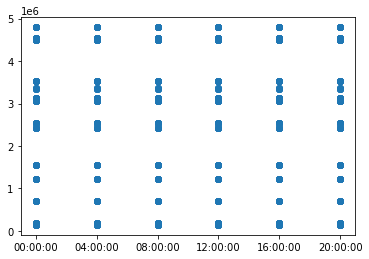

In [18]:
# ignore
plt.scatter(x=flatiron['TIME'], y=(flatiron['EXITS']).astype(int))

This is not very helpful because times are in four-hour increments. 

To verify, let's sample the data and look at the TIME column: 16, 12, 0, 8, etc.

In [19]:
flatiron.sample(200)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
3941,A030,R083,01-00-00,23 ST,NRW,BMT,07/01/2019,16:00:00,REGULAR,98095,144112,2019-07-01 16:00:00,242207
4408,A031,R083,00-03-00,23 ST,NRW,BMT,07/02/2019,12:00:00,REGULAR,2816627,4793849,2019-07-02 12:00:00,7610476
4490,A031,R083,00-03-02,23 ST,NRW,BMT,07/02/2019,04:00:00,REGULAR,149119,187538,2019-07-02 04:00:00,336657
4454,A031,R083,00-03-01,23 ST,NRW,BMT,07/03/2019,04:00:00,REGULAR,4075980,4499820,2019-07-03 04:00:00,8575800
4240,A030,R083,01-06-01,23 ST,NRW,BMT,07/02/2019,12:00:00,REGULAR,85864759,1224417,2019-07-02 12:00:00,87089176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,A031,R083,00-03-00,23 ST,NRW,BMT,07/02/2019,20:00:00,REGULAR,2817002,4794219,2019-07-02 20:00:00,7611221
4416,A031,R083,00-03-00,23 ST,NRW,BMT,07/03/2019,20:00:00,REGULAR,2817619,4795038,2019-07-03 20:00:00,7612657
4025,A030,R083,01-00-02,23 ST,NRW,BMT,07/01/2019,16:00:00,REGULAR,5206668,2424894,2019-07-01 16:00:00,7631562
4400,A031,R083,00-03-00,23 ST,NRW,BMT,07/01/2019,04:00:00,REGULAR,2815994,4792466,2019-07-01 04:00:00,7608460


In [20]:
# ignore
flatiron[flatiron["C/A"]=="A030"].shape

(336, 13)

In [ ]:
# ignore
flatiron[flatiron["C/A"]=="A031"].shape

In [ ]:
# ignore
flatiron[flatiron["UNIT"]=="R083"].shape

In [ ]:
# ignore
252+336

In [ ]:
# ignore
flatiron[flatiron["UNIT"]=="R083"].tail()

Could do a groupby to aggregate the average or sum of entries at each time of day. 

What about by days of the week?

What about by days of the week?

In [ ]:
# ignore
plt.scatter(x=flatiron['DATE'], y=(flatiron['EXITS']).astype(int))

I don't think I understand yet what the 'EXITS' column really means yet.  Even within the same week at the same time interval 

there are many datapoints.

To go further, we probably need to review the 'codebook' for this dataset. Otherwise we can end up with a garbage-in analysis

*******
## Update 


I've figured out the issue here. The entries and exits columns are actually cumulative counts for each specific counting device. Therefore to extract the data we need, we need to is the following:
0. Convert ENTRIES and EXITS columns to integers so we can compute their numerical diff
1. Convert it into a list of dataframes where each dataframe in the list corresponds to a counting device. (To do this we first extract the unique values in the device column; then cycle through that list, using each item to extract rows matching it.
2. Then cycle through each data frame in our list of dataframes
    * sort it by TIME just to be on the safe side
    * create two new columns that contains the difference between each row's ENTRY and EXIT counts and that of the previous row
3. Append each of dataframe in the result list into a one list
4. Sort by date and time to find graph these to discover days and times with highest traffic
5. might use a calendar library ot convert date to day of week and do groupby on that
6. could also graph traffic against TIME, while ignorning day
7. Ideally we could drill down and find the day-of-week and time that consistently have the highest traffic during the summer. This would require the above pipeline for multiple weeks and multiple years, and pooling that data.



Unfortunately the "Field description" actually doesn't explain which column corresponds to the counting device. Is it `C/A` or it it `Unit`? 

In [ ]:
flatiron.head()

Let's see how many rows are in a single `C/A` and `UNIT`

In [ ]:
flatiron[flatiron["C/A"]=="A030"].shape

In [ ]:
flatiron[flatiron["C/A"]=="A031"].shape

In [ ]:
flatiron[flatiron["UNIT"]=="R083"].shape

In [ ]:
336+252 == 588

Let's look at the seam between `C/A` == A030 and and A031, to see if the cumulative count restarts.

In [ ]:
flatiron[flatiron["UNIT"]=="R083"].iloc[330:340]

Indeed, the counting in `EXITS` jumps from 1230536 to 714199 at the seam from A030 to A031, so it seems that the C/A column contains the device label.

Looking further, however, what about the SCP colomn? Let's observe what happens to the EXITS column when SCP shifts.

In [ ]:
flatiron[flatiron["UNIT"]=="R083"].iloc[375:380]

Whoops. When SCP changes, the EXITS counts start again. So actually the combination of the C/A and SCP columns seem to 
define a counting stream

#### Try out a graph using the data from just one device

If this pans out, we'll go back and do this data cleaning at an earlier stage so it affects the entire dataset

In [21]:
FI_device_A031zeroSCP = flatiron[ (flatiron["C/A"]=="A031") & (flatiron["SCP"]=="00-00-00")].copy()
FI_device_A031zeroSCP.sort_values(by=["DATE", "TIME"]).head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total
4261,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,00:00:00,REGULAR,1319870,707549,2019-06-29 00:00:00,2027419
4262,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,04:00:00,REGULAR,1319957,707564,2019-06-29 04:00:00,2027521
4263,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,08:00:00,REGULAR,1319976,707589,2019-06-29 08:00:00,2027565
4264,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,12:00:00,REGULAR,1320173,707729,2019-06-29 12:00:00,2027902
4265,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,16:00:00,REGULAR,1320593,707888,2019-06-29 16:00:00,2028481
4266,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,20:00:00,REGULAR,1321058,708069,2019-06-29 20:00:00,2029127
4267,A031,R083,00-00-00,23 ST,NRW,BMT,06/30/2019,00:00:00,REGULAR,1321301,708141,2019-06-30 00:00:00,2029442
4268,A031,R083,00-00-00,23 ST,NRW,BMT,06/30/2019,04:00:00,REGULAR,1321352,708151,2019-06-30 04:00:00,2029503
4269,A031,R083,00-00-00,23 ST,NRW,BMT,06/30/2019,08:00:00,REGULAR,1321373,708173,2019-06-30 08:00:00,2029546
4270,A031,R083,00-00-00,23 ST,NRW,BMT,06/30/2019,12:00:00,REGULAR,1321429,708609,2019-06-30 12:00:00,2030038


In [22]:
FI_device_A031zeroSCP["Exit diffs"] = FI_device_A031zeroSCP["EXITS"].diff()

In [23]:
FI_device_A031zeroSCP[FI_device_A031zeroSCP["TIME"]=="00:00:00"]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Traffic_running_total,Exit diffs
4261,A031,R083,00-00-00,23 ST,NRW,BMT,06/29/2019,00:00:00,REGULAR,1319870,707549,2019-06-29,2027419,NaN
4267,A031,R083,00-00-00,23 ST,NRW,BMT,06/30/2019,00:00:00,REGULAR,1321301,708141,2019-06-30,2029442,72.0
4273,A031,R083,00-00-00,23 ST,NRW,BMT,07/01/2019,00:00:00,REGULAR,1321652,709718,2019-07-01,2031370,74.0
4279,A031,R083,00-00-00,23 ST,NRW,BMT,07/02/2019,00:00:00,REGULAR,1324150,710974,2019-07-02,2035124,64.0
4285,A031,R083,00-00-00,23 ST,NRW,BMT,07/03/2019,00:00:00,REGULAR,1326813,712194,2019-07-03,2039007,54.0
4291,A031,R083,00-00-00,23 ST,NRW,BMT,07/04/2019,00:00:00,REGULAR,1328951,713250,2019-07-04,2042201,50.0
4297,A031,R083,00-00-00,23 ST,NRW,BMT,07/05/2019,00:00:00,REGULAR,1330092,713603,2019-07-05,2043695,30.0


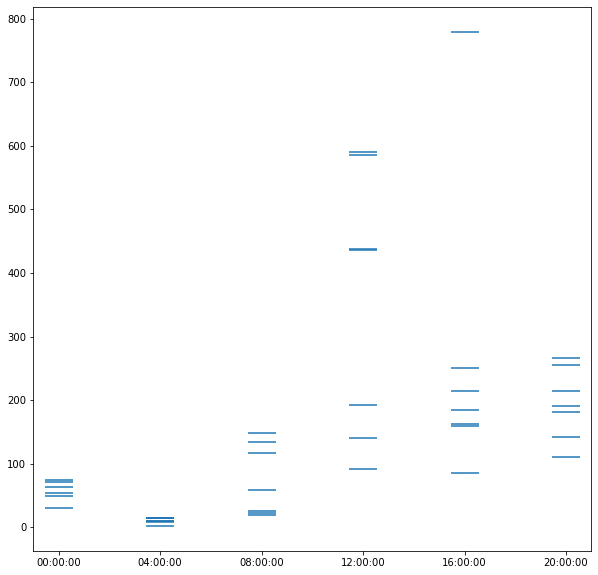

In [24]:
plt.figure(figsize=(10,10))
plt.scatter( x=FI_device_A031zeroSCP['TIME'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

#### It seems as though **_8am-12 noon_** time (at least on certain days) as well as **_4pm-8pm_** are the times with the most traffic.

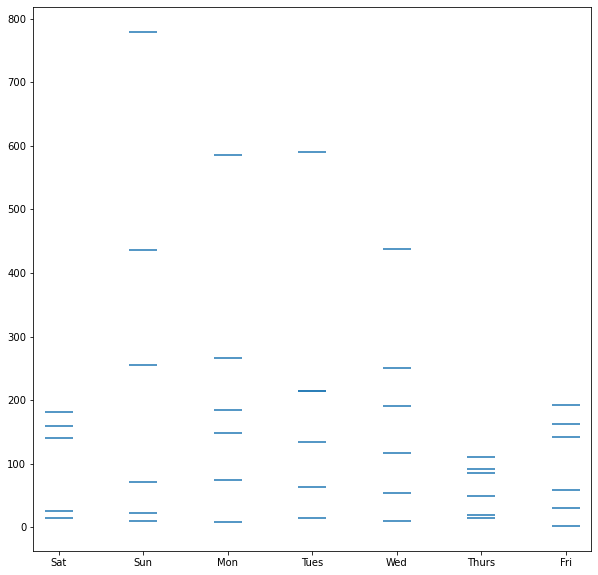

In [25]:
x_labels = ['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri'] 
plt.figure(figsize=(10,10))
positions = range(7)
plt.xticks(positions, x_labels)
plt.scatter( x=FI_device_A031zeroSCP['DATE'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

#### It seems as though Wednesday and Thursday have the most traffic.

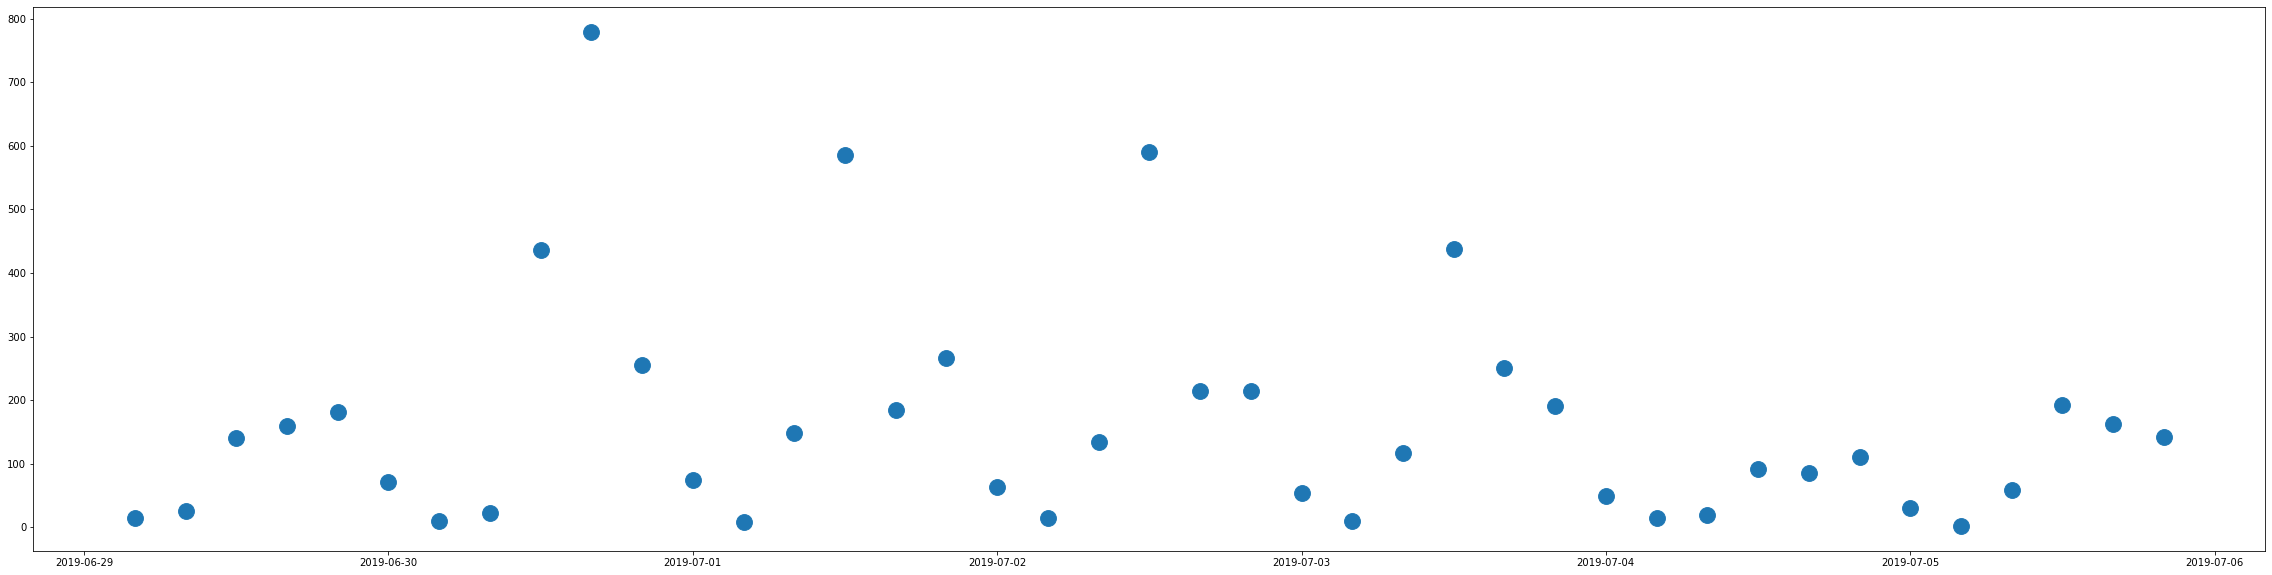

In [26]:
#x_labels = ['Midnight', 'Dawn', 'Morning', 'Afternoon', 'Dusk', 'Evening', 'Night'] 

#fig, ax = plt.subplots()
#fig.figsize=(40,10)
plt.figure(figsize=(40,10))
#positions = range(7*6)
#plt.xticks(positions, x_labels)
#plt.xaxis.set_major_locator(MultipleLocator(20))
plt.scatter( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(1000,))
#ax.plot( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(300,))

Attempts to format the x-axis labels with the days of the week have not progressed very far.

In [ ]:
# #plt.figure(figsize=(40,10))
# graph = pd.Series(FI_device_A031zeroSCP['Datetime'], FI_device_A031zeroSCP['Exit diffs'])
# ax = graph.plot()
# weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
#               4:'FRI', 5:'SAT', 6:'SUN'}
# xs = sorted(ax.get_xticks(minor='both'))
# wd = graph.index[xs - xs[0]].map(pd.Timestamp.weekday)

# ax.set_xticks(xs)
# ax.set_xticks([], minor=True)
# ax.set_xticklabels([weekday_map[d] for d in wd])
# #plt.scatter( x=FI_device_A031zeroSCP['Datetime'], y=FI_device_A031zeroSCP['Exit diffs'], marker='.', s=(1000,))

In [27]:
time_series = FI_device_A031zeroSCP.set_index('Datetime')['Exit diffs']

In [28]:
import seaborn as sns
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(40, 10)})

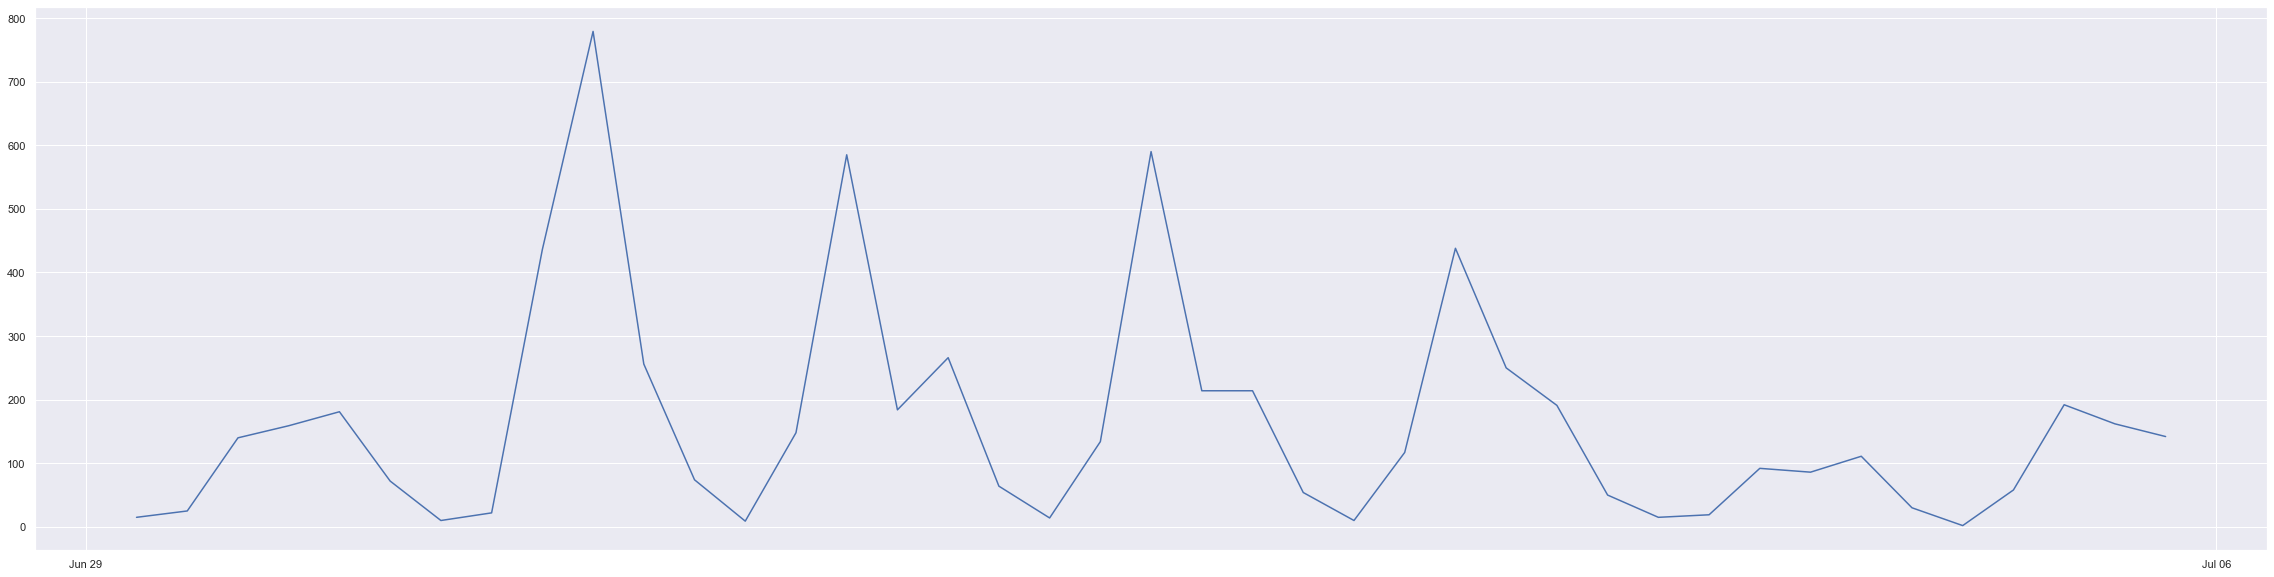

In [29]:
fig, ax = plt.subplots()
ax.plot(time_series)
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SATURDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

******

Meanwhile, what about the zip code of stations? We'll need to merge this with the turnstile data if we want to 

identify stops that that are higher-income neighborhoods, by joining (merging) with a demographics/census dataset

In [30]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [31]:
stations.sample(10)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
194,194,194,A64,IND,Liberty Av,111 St,Q,A,Elevated,40.684331,-73.832163,Manhattan,Lefferts Blvd,0,NaN
119,120,120,L08,BMT,Canarsie,Bedford Av,Bk,L,Subway,40.717304,-73.956872,Manhattan,Canarsie - Rockaway Parkway,1,NaN
30,31,31,R35,BMT,4th Av,25 St,Bk,R,Subway,40.660397,-73.998091,Manhattan,Bay Ridge - 95 St,0,NaN
429,429,429,216,IRT,Lenox - White Plains Rd,Freeman St,Bx,2 5,Elevated,40.829993,-73.891865,Wakefield - Eastchester,Manhattan,0,NaN
485,511,511,S21,SIR,Staten Island,Oakwood Heights,SI,SIR,Open Cut,40.565110,-74.126320,St George,Tottenville,0,NaN
169,169,169,A34,IND,8th Av - Fulton St,Canal St,M,A C E,Subway,40.720824,-74.005229,Uptown - Queens,Downtown & Brooklyn,0,NaN
106,107,107,M23,BMT,Jamaica,Broad St,M,J Z,Subway,40.706476,-74.011056,Brooklyn,NaN,0,NaN
107,108,108,M01,BMT,Myrtle Av,Middle Village-Metropolitan Av,Q,M,Elevated,40.711396,-73.889601,Manhattan,NaN,1,NaN
462,461,461,R09,BMT,Astoria,Queensboro Plaza,Q,N W,Elevated,40.750582,-73.940202,Astoria - Flushing,Manhattan,0,NaN
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN


Whereas the stop names in the turnstile dataset were all caps, these are in title case. 

Who knows if truly corresponding names are used for each station?

As a preliminary step to finding out, lets convert that columns to upper 

In [ ]:
stations['Stop Name'] = stations['Stop Name'].str.upper() 

In [ ]:
# sanity check
stations.sample(5)

In [ ]:
stations.columns

In [ ]:
stations.shape

## -------- CC - Adding Income Data to Stations by Lat/Lng --------
1. import uszipcode package
2. use lat/lng function to pull median hh income from database

#### Other potentially useful variables from the zipcode list:
zipcode_type='Standard', <br>
major_city='Derwood', <br>
county='Montgomery County', <br>
state='MD', <br>
radius_in_miles=4.0, <br>
population=14295, <br>
population_density=1090.0, <br>
housing_units=5018, <br>
occupied_housing_units=4889,  <br>
median_home_value=453900, <br>
median_household_income=120603

#### Other interesting metrics from this data can be found here: https://pypi.org/project/uszipcode/

In [32]:
### uszip method
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)

In [33]:
def getincome(_lat,_lon):
    income = search.by_coordinates(_lat,_lon, radius=2,returns=1)[0].median_household_income
    return income

In [34]:
stations['income'] = stations.apply(lambda row:  getincome(row['GTFS Latitude'], row['GTFS Longitude']) ,axis=1)                                              

In [35]:
# check if income is in df
stations.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,income
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,57525.0
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,49924.0
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,48720.0


In [ ]:
print(" \nCount total NaN at each column in a Station : \n\n", stations.isnull().sum(), "# row/cols",stations.shape)

In [ ]:
print(stations[stations['income'].isna()]) 

In [ ]:
lat=40.764811 
lon=-73.973347

result = search.by_coordinates(lat=lat,lng=lon, radius=5,returns=1)[0].median_household_income    

### We may have to either impute these values separately with the income from the nearest station (i.e. widen the radius)

## --------- CC - END OF INCOME MERGE ----------

## --------- CC - Read in xwalk for booth to stations data ---------
(downloaded from: https://qri.cloud/nyc-transit-data/remote_complex_lookupcsv)

There is no direct link between the stations df and the turnstile df. Therefore we found a link using complex_id from stations and complex_id from xwalk. The xwalk contains C/A, Unit, Station, Line to merge with the turnstile data

You need to have the .csv file saved in the location of the program

In [117]:
station_xwalk = pd.read_csv('booth_station_xwalk.csv')

In [118]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
1,R001,A058,635.0,WHITEHALL ST,R1,BMT
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT


In [119]:
# complex id is float64 but needs to convert to int. Can only do by filling the nans with 0 first
import numpy as np
station_xwalk['complex_id2'] = station_xwalk['complex_id'].fillna(0,inplace=True)
station_xwalk['complex_id2'] = station_xwalk['complex_id'].apply(np.int64)

In [120]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division,complex_id2
0,R001,A060,635.0,WHITEHALL ST,R1,BMT,635
1,R001,A058,635.0,WHITEHALL ST,R1,BMT,635
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT,635
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT,628
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT,628


In [133]:
# merge xwalk to stations by complex id
stations_complex = stations.merge(station_xwalk[["remote","booth","station","line_name","division","complex_id2"]], left_on="Complex ID", right_on="complex_id2")

In [134]:
stations_complex.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,...,South Direction Label,ADA,ADA Notes,income,remote,booth,station,line_name,division,complex_id2
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,...,Manhattan,0,NaN,57525.0,R095,R515,DITMARS BL-31 S,NQ,BMT,1
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,...,Manhattan,1,NaN,49924.0,R094,R514,HOYT ST-ASTORIA,NQ,BMT,2
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,...,Manhattan,0,NaN,49924.0,R093,R513,GRAND-30 AVE,NQ,BMT,3
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,...,Manhattan,0,NaN,49924.0,R092,R512,BROADWAY-31 ST,NQ,BMT,4
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,...,Manhattan,0,NaN,48720.0,R091,R511,WASHINGTON-36 A,NQ,BMT,5


In [137]:
# merge stations to turnstile df
# !! do NOT merge by station field - we can probably drop the one from turnstile
# we might want to add the DIVISION var back for merging

turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex,  how='left', left_on=['C/A','UNIT'], right_on = ['booth','remote'])

In [138]:
turnstiles_4hourly_w_station_info.head()

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,...,South Direction Label,ADA,ADA Notes,income,remote,booth,station,line_name,division,complex_id2
0,A002,R051,02-00-00,59 ST,2019-06-29 00:00:00,9526917,NaT,NaN,0,NaN,...,Downtown & Brooklyn,0.0,NaN,115519.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
1,A002,R051,02-00-00,59 ST,2019-06-29 00:00:00,9526917,NaT,NaN,0,NaN,...,Downtown & Brooklyn,0.0,NaN,109019.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
2,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,...,Downtown & Brooklyn,0.0,NaN,115519.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
3,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,...,Downtown & Brooklyn,0.0,NaN,109019.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
4,A002,R051,02-00-00,59 ST,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0,12,4.0,...,Downtown & Brooklyn,0.0,NaN,115519.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0


In [139]:
# We're capping the ppl per hour at 10k. Should we be doing this??
turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]

In [140]:
turnstiles_4hourly_w_station_info_cleaner.head()

,C/A,UNIT,SCP,STATION,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,...,South Direction Label,ADA,ADA Notes,income,remote,booth,station,line_name,division,complex_id2
2,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,...,Downtown & Brooklyn,0.0,NaN,115519.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
3,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,...,Downtown & Brooklyn,0.0,NaN,109019.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
4,A002,R051,02-00-00,59 ST,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0,12,4.0,...,Downtown & Brooklyn,0.0,NaN,115519.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
5,A002,R051,02-00-00,59 ST,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0,12,4.0,...,Downtown & Brooklyn,0.0,NaN,109019.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0
6,A002,R051,02-00-00,59 ST,2019-06-29 16:00:00,9527422,2019-06-29 12:00:00,9527144.0,16,4.0,...,Downtown & Brooklyn,0.0,NaN,115519.0,R051,A002,LEXINGTON AVE,456NQR,BMT,613.0


In [141]:
# Here we can choose which "station" variable to keep. right now it's from turnstile
turnstile_summary = turnstiles_4hourly_w_station_info_cleaner[["STATION", "Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude","income"]]

In [142]:
turnstile_summary.head()

,STATION,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
2,59 ST,2019-06-29 08:00:00,Saturday,5,8,5.333333,8.875,40.762660,-73.967258,115519.0
3,59 ST,2019-06-29 08:00:00,Saturday,5,8,5.333333,8.875,40.762526,-73.967967,109019.0
4,59 ST,2019-06-29 12:00:00,Saturday,5,12,5.500000,39.000,40.762660,-73.967258,115519.0
5,59 ST,2019-06-29 12:00:00,Saturday,5,12,5.500000,39.000,40.762526,-73.967967,109019.0
6,59 ST,2019-06-29 16:00:00,Saturday,5,16,5.666667,69.500,40.762660,-73.967258,115519.0


In [ ]:
# Commenting out hte original merge below which i don't think would've worked

In [ ]:
# Back to turnstile df, merge Station (with income) and keep rows with ppl per hour between 0-10000
# turnstiles_4hourly_w_station_info = turnstiles_4hourly.merge(stations_complex, left_on="STATION", right_on="Stop Name")
# turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]
# turnstile_summary = turnstiles_4hourly_w_station_info_cleaner[["STATION", "Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude"]]

## -------- CC - END OF STATIONS/Xwalk/Turnstiles Merge ---------

### Composite of all stations, day-by-day traffic people per hour
(haven't yet made title or labeled y axis--needs to be done)

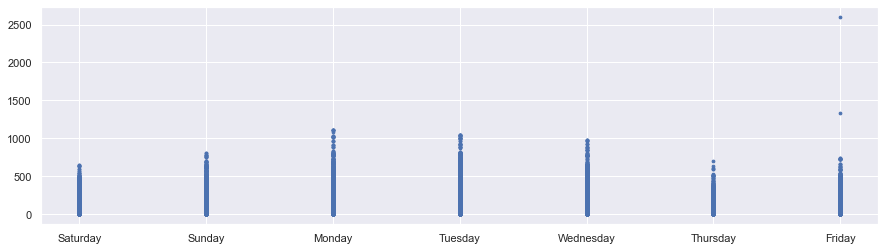

In [143]:
plt.figure(figsize=(15,4))
plt.scatter( x=turnstile_summary['Day_of_week'], y=turnstile_summary['People_per_hour'], marker='.', s=(30,))


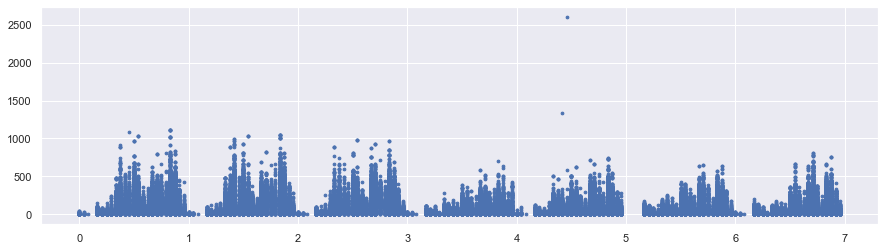

In [144]:
plt.figure(figsize=(15,4))
plt.scatter( x=turnstile_summary['Day_hour'], y=turnstile_summary['People_per_hour'], marker='.', s=(30,))


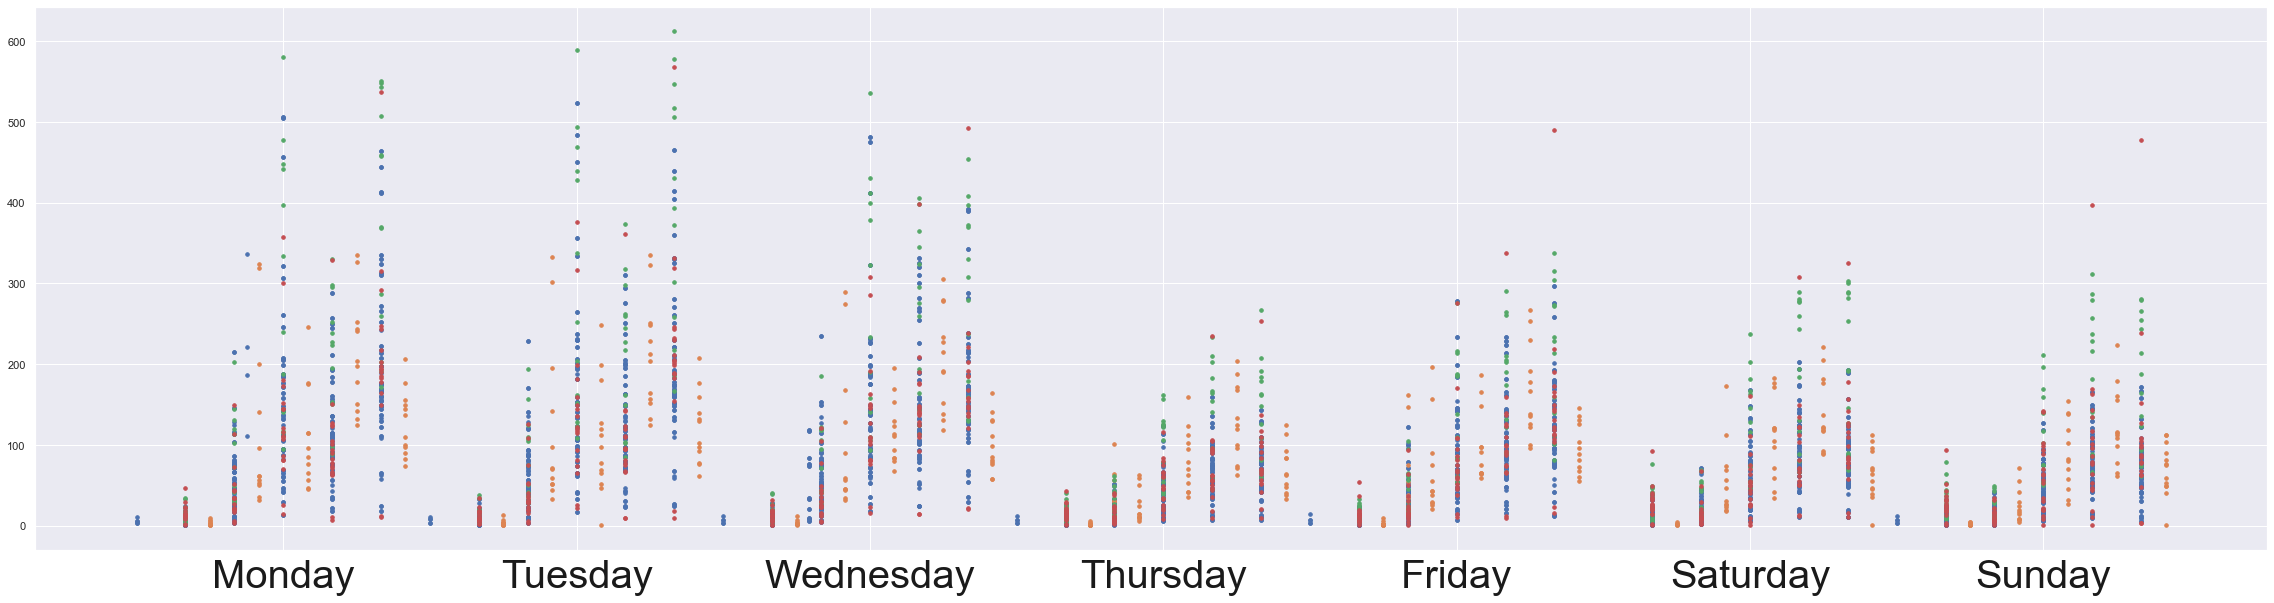

In [145]:
import numpy as np
station_list = turnstile_summary['STATION'].unique().tolist()
ticks_x = np.linspace(0.5, 6.5, 7)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.xticks(ticks_x, days, fontsize = '40', color='k');
size_ = 50
plt.scatter( x=turnstile_summary[turnstile_summary['STATION']==station_list[0]]['Day_hour'], y=turnstile_summary[turnstile_summary['STATION']==station_list[0]]['People_per_hour'], marker='.', s=(size_,))
plt.scatter( x=turnstile_summary[turnstile_summary['STATION']==station_list[1]]['Day_hour'], y=turnstile_summary[turnstile_summary['STATION']==station_list[1]]['People_per_hour'], marker='.', s=(size_,))
plt.scatter( x=turnstile_summary[turnstile_summary['STATION']==station_list[2]]['Day_hour'], y=turnstile_summary[turnstile_summary['STATION']==station_list[2]]['People_per_hour'], marker='.', s=(size_,))
plt.scatter( x=turnstile_summary[turnstile_summary['STATION']==station_list[3]]['Day_hour'], y=turnstile_summary[turnstile_summary['STATION']==station_list[3]]['People_per_hour'], marker='.', s=(size_,))
# Chuck:
# Can adjust the linspace so the Day of the Week looks right on the graph
# station_list is just a placeholder I was using to get some station names
# So if you do plt.scatter several times, it can plot each station individually in its own color. I know there's a way to code that better, but can't do it myself quickly right now

# Josh:
# This think this looks really helpful. I altered a couple of things as you'll see above
# I think the colors could be used if focusing in on the four stations around the
# district, which I isolated far up above. It would be especially impressive it there was a legend indicating those station names
# With the colors I feel that the grey background detracts, and I don't remember how to make the background white, probably it's
# about turning of the grid, not sure.

# It would also be great to have a scatterplot by of lat-by-long of all stations that uses size or opacity to indicate
# traffic or income, or vice versa


### Flatiron train station in particular is shown below

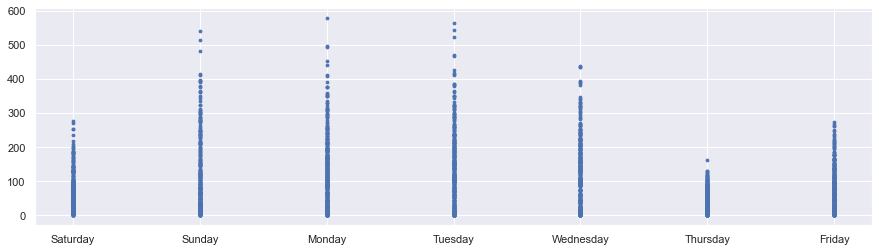

In [146]:
flatiron_turnstile_summary = turnstile_summary[turnstile_summary['STATION'].str.contains('23 ST')]
plt.figure(figsize=(15,4))
plt.scatter( x=flatiron_turnstile_summary['Day_of_week'], y=flatiron_turnstile_summary['People_per_hour'], marker='.', s=(30,))


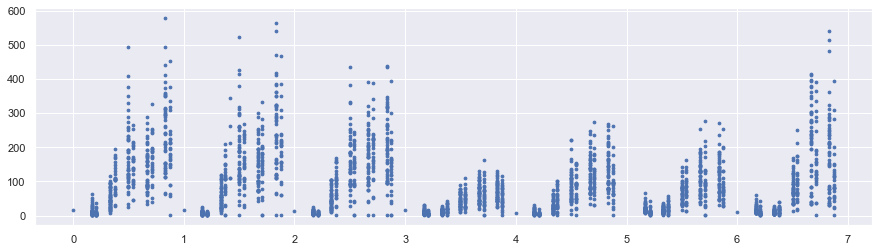

In [147]:
plt.figure(figsize=(15,4))
plt.scatter( x=flatiron_turnstile_summary['Day_hour'], y=flatiron_turnstile_summary['People_per_hour'], marker='.', s=(30,))


## This dataframe view `turnstile_summary` would be a good one with which to merge income data.  It would also be a good one to make a lat-long scatterplot to indicate traffic.  

Merge (join) the turnstile and stations dataframes.  We probably have too many columms here and should pare down.

## ----------- CC - Geo location and Income visuals --------------

Keep in mind, as noted earlier, the data needs to be at the unique station level in order for this to work properly.
The merge of turnstile to station included a middle step with a xwalk. This is not coming out 1:1 in the merge so we 
need to fix the merge first then provide the graphs.

In [149]:
turnstile_summary.head()

,STATION,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
2,59 ST,2019-06-29 08:00:00,Saturday,5,8,5.333333,8.875,40.762660,-73.967258,115519.0
3,59 ST,2019-06-29 08:00:00,Saturday,5,8,5.333333,8.875,40.762526,-73.967967,109019.0
4,59 ST,2019-06-29 12:00:00,Saturday,5,12,5.500000,39.000,40.762660,-73.967258,115519.0
5,59 ST,2019-06-29 12:00:00,Saturday,5,12,5.500000,39.000,40.762526,-73.967967,109019.0
6,59 ST,2019-06-29 16:00:00,Saturday,5,16,5.666667,69.500,40.762660,-73.967258,115519.0


<AxesSubplot:xlabel='GTFS Longitude', ylabel='GTFS Latitude'>

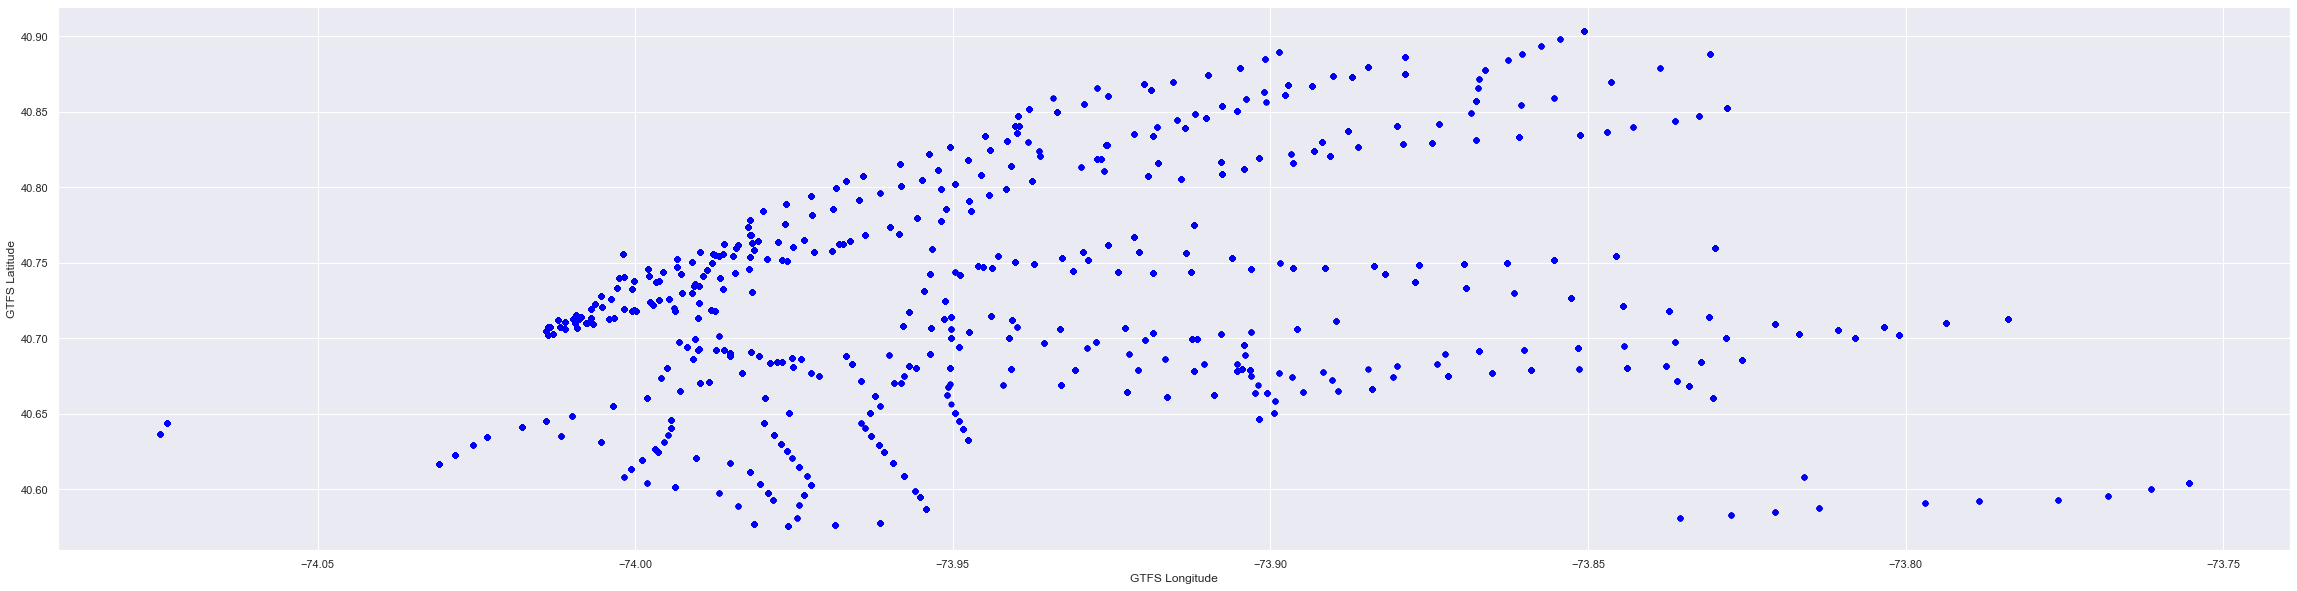

In [158]:
# Very basic plot of lat/long
turnstile_summary.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude", alpha=0.1, color="blue")
#save_fig("basic lat/lon")

### CC - This is the lat/long graph (stations as bubbles) and income as color
. Need to fix merge to get data at a unique station level
. Can make something more complex by adding map onto the graph

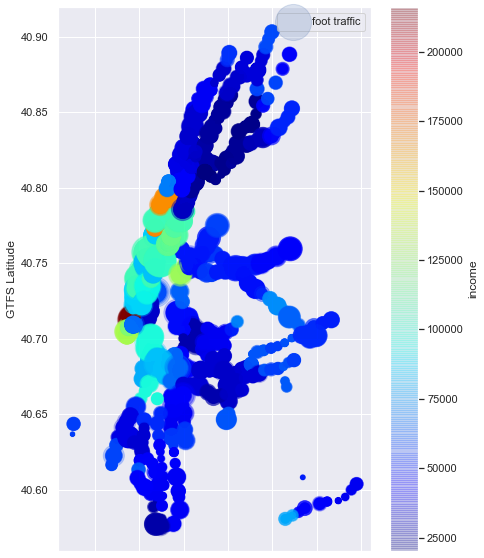

In [168]:

turnstile_summary.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude",
    s=turnstile_summary['People_per_hour'], label="foot traffic",
    c="income", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.2, figsize=(7,10),
)
plt.legend()
#save_fig("housing_prices_scatterplot")
plt.show()

## ------------ CC - END income geo graphs ------------

In [148]:
#turnstile_station = df.merge(stations, left_on="STATION", right_on="Stop Name")
turnstile_station = turnstile_summary.merge(stations[['income', 'Stop Name']], left_on="STATION", right_on="Stop Name")
turnstile_station.drop(columns=["Stop Name"], inplace=True)
turnstile_station

,STATION,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income_x,income_y


For this to be useful regarding income levels in neighborhoods (which will probably exists by zip code), 

we'd have to merge this station we'd have to use library that gets zip code from lat and longitude

I believe the one to use is probably geopy: 
[geopy](https://geopy.readthedocs.io/en/stable/)

These might or not be helpful:

[income by zip](https://www.incomebyzipcode.com/newyork)

[open data nyc](https://opendata.cityofnewyork.us/)    

# I think the code below here should be re-oriented to draw instead from `turnstile_summary` using its column `People_per_hour`

In [ ]:
df.head()

In [ ]:
#Check for abnormalities. Less than zero are changed to positive and greater than the max are reset to 0
def daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

In [ ]:
#sort "ENTRIES" by including "Datetime"
(df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False));

In [ ]:
#Sort ENTRIES and keep the ending value of the day
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
                .ENTRIES.first().reset_index().copy()

In [ ]:
df_4hourly = df.groupby(["C/A", "UNIT", "SCP", "STATION", "Datetime"])\
                .ENTRIES.first().reset_index().copy()

In [ ]:
df_4hourly.head()

In [ ]:
#Grab the previous row's DATE and ENTRIES and pull into current column for all columns.
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\
                                          .transform(lambda grp: grp.shift(1)));

In [ ]:
df_daily.head()

In [ ]:
#Use daily_counts function 
df_daily["DAILY_ENTRIES"] = df_daily.apply(daily_counts, axis=1, max_counter=1000000);

In [ ]:
df_daily.head()

In [ ]:
#Dataframe for STATION and DATE and sum on DAILY ENTRIES.

df_daily_stations = df_daily.groupby(['STATION', 'DATE'])['DAILY_ENTRIES'].sum().reset_index().sort_values(['DATE'])

In [ ]:
df_median = df_daily_stations.groupby(['STATION'])['DAILY_ENTRIES'].agg(['median']).reset_index().sort_values(['median'], ascending=False)
df_median_10 = df_median[:10]

In [ ]:
#top ten stations bar plot

df_median_10.plot.bar(x='STATION',y='median',color='blue')
plt.xlabel('Stations', fontsize=30)
plt.ylabel('Median', fontsize=30)
plt.title("Top 10 Stations of Median Entries ", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(rotation=45)
plt.legend(["Median"], prop={"size":20})

plt.show()

In [ ]:
df.head()

In [ ]:
df_median = df.groupby('STATION')['ENTRIES'].sum().sort_values(ascending=False)
df_median.head(10)

In [ ]:
fig1 = plt.figure(figsize=[8,6])
ax1 = sns.distplot(df_median,bins=50,kde=False)
#plt.xlim([0,410000])
plt.ylabel('No. of Stations',fontsize=15, weight='bold')
plt.xlabel('Total Traffic', fontsize=15, weight='bold')
ax1.annotate('Highest traffic Stations', xy=(0.73, 0.08), xytext=(0.73, 0.16), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom', arrowprops=dict(arrowstyle='-[, widthB=9.0, lengthB=1', lw=8.0),color='blue')                            
                            
plt.title('Distribution of Traffic Across Stations',fontsize=15,weight='bold')
sns.despine()

plt.savefig('histplot.png',transparent=True, bbox_inches='tight')

In [ ]:
#Gives top 5
df.groupby(['LINENAME', 'STATION']).sum().sort_values(by='ENTRIES',ascending=False).head(10)